In [12]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../')

from model.LP import LP
from model.DeepLP import DeepLP
from model.DeepLP_RBF import DeepLP_RBF
from model.DeepLP_WeightedRBF import DeepLP_WeightedRBF
from model.DeepLP_RBF_Sparse import DeepLP_RBF_Sparse
from model.DeepLP_WeightedRBF_Sparse import DeepLP_WeightedRBF_Sparse

from model.utils import *

iris = False
cora = not iris
label_prob = 0.01
hard = True
percentile = 10

sigma = 3

%matplotlib inline

### Iris Data

In [13]:
if iris:
    # get labels, features and weights
    # load iris data
    iris   = datasets.load_iris()
    data   = iris["data"]
    labels = iris["target"]

    # get label 0 and 1, and corresponding data
    labels = labels[labels < 2]
    data = data[np.where(labels < 2)]

In [14]:
if cora:
    nodes = pd.read_csv('cora/selected_contents.csv',index_col=0,)
    graph = np.loadtxt('cora/graph.csv',delimiter=',')
    id_    = np.array(nodes.index)
    labels = np.array(nodes['label'])
    data   = nodes.loc[:,'feature_0':].as_matrix()

### Cora Data

### Data Preparation

In [15]:
LX, Ly, UX, Uy, Uy_sol, unlabeled_points = random_unlabel(data,labels,label_prob=label_prob,hard=hard)
features = np.vstack((LX,UX))
if iris:
    weights = rbf_kernel(features,s=sigma,percentile=percentile)
if cora:
    weights = rbf_kernel(features,G=graph)

true_labels = np.hstack((Ly,Uy_sol))
num_features = features.shape[1]
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled
if iris:
    graph = (weights > 0).astype(int)

In [16]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))
theta = np.ones(num_features)

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,num_nodes)

In [17]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,num_nodes)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,num_nodes),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,num_nodes),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [18]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

In [20]:
lp = LP(num_nodes,num_labeled)

In [24]:
    def t(W):
        return W / np.sum(W, axis=0, keepdims=True)

    def tnorm(W):
        T = t(W)
        Tnorm = T / np.sum(T, axis=1, keepdims=True)
        return Tnorm

    def closed(W,Ly):
        n = len(Ly)
        Tnorm = tnorm(W)
        Tuu_norm = Tnorm[n:,n:]
        Tul_norm = Tnorm[n:,:n]
        a = (np.identity(len(Tuu_norm))-Tuu_norm)
        b = Tul_norm @ Ly
        Uy_lp = np.linalg.solve(a, b)
        return Uy_lp

    def iter_(W,Ly,Uy,iter_):
        Tnorm = tnorm(W)
        Y = np.hstack((Ly,Uy))
        
        for i in range(iter_):
            Y = np.dot(Y,Tnorm)
            Y[:num_labeled] = Ly

        return(Y[num_labeled:])

In [25]:
Uy_pred_prob = iter_(weights,Ly,Uy,1)

In [31]:
np.sum(unlabeled_points),len(unlabeled_points)

(2461, 2485)

## Sparse

In [19]:
dlp = DeepLP_RBF_Sparse(100, num_nodes, features, graph, sigma, lr=0.1)

In [9]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))

Accuracy: 0.440065014222
RMSE: 0.629418935392


In [10]:
dlp.train(data,test_data,1000)

epoch: -1 labeled loss: 0.289459 unlabeled loss: 0.464612 accuracy: 0.444064 sol unlabeled loss: 0.46227 sol accuracy: 0.440065
--- 6.885742902755737 seconds ---
sigma: 3.0
epoch: 0 labeled loss: 0.288412 unlabeled loss: 0.463858 accuracy: 0.444366 sol unlabeled loss: 0.461515 sol accuracy: 0.440065
--- 1.3388168811798096 seconds ---
sigma: 3.1
epoch: 1 labeled loss: 0.287495 unlabeled loss: 0.46323 accuracy: 0.444165 sol unlabeled loss: 0.460883 sol accuracy: 0.440065
--- 0.546454906463623 seconds ---
sigma: 3.19945
epoch: 2 labeled loss: 0.286689 unlabeled loss: 0.462704 accuracy: 0.444249 sol unlabeled loss: 0.460355 sol accuracy: 0.440471
--- 0.5210580825805664 seconds ---
sigma: 3.29803
epoch: 3 labeled loss: 0.285981 unlabeled loss: 0.462263 accuracy: 0.44383 sol unlabeled loss: 0.459912 sol accuracy: 0.439252
--- 0.5413203239440918 seconds ---
sigma: 3.39548
epoch: 4 labeled loss: 0.285355 unlabeled loss: 0.461892 accuracy: 0.443645 sol unlabeled loss: 0.459539 sol accuracy: 0.4

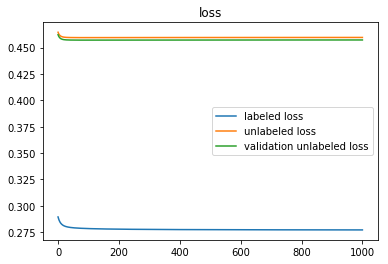

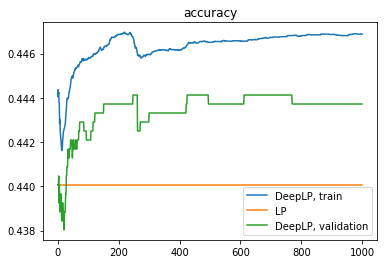

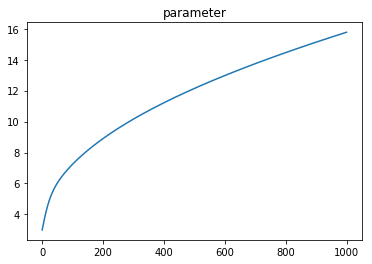

In [11]:
dlp.plot()

In [8]:
dlp = DeepLP_WeightedRBF_Sparse(100, num_nodes, features, graph, sigma, theta, lr=0.1, regularize=0.001)

In [9]:
pred_dlp_s = dlp.labelprop(test_data)
Uy_dlp_s = np.rint(pred_dlp_s[:,num_labeled:]).reshape(num_unlabeled)
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_s))
print("RMSE:", rmse(Uy_sol,Uy_dlp_s))
# print("Objective:", objective(Ly,Uy_dlp_s,dlp.get_val(dlp.W)))

Accuracy: 0.440065014222
RMSE: 0.629418935392


In [10]:
dlp.train(data,test_data,1000)

epoch: -1 labeled loss: 0.289459 unlabeled loss: 0.464612 accuracy: 0.444064 sol unlabeled loss: 0.46227 sol accuracy: 0.440065
--- 6.993393182754517 seconds ---
epoch: 0 labeled loss: 0.279632 unlabeled loss: 0.465444 accuracy: 0.445121 sol unlabeled loss: 0.463114 sol accuracy: 0.442097
--- 1.1119039058685303 seconds ---
theta: [ 1.09999204  1.09999645  1.09999251  1.09997988  1.09997714  0.90000463
  0.900002    0.90000337  0.90000969  1.09999537  1.09997928  0.90000635
  0.90000319  1.0999341   1.09998262  0.90008277  0.90000272  1.09999335
  0.90000439]
epoch: 1 labeled loss: 0.271094 unlabeled loss: 0.466767 accuracy: 0.445791 sol unlabeled loss: 0.464448 sol accuracy: 0.442909
--- 0.6222500801086426 seconds ---
epoch: 2 labeled loss: 0.263655 unlabeled loss: 0.468348 accuracy: 0.445808 sol unlabeled loss: 0.466035 sol accuracy: 0.441284
--- 0.6454641819000244 seconds ---
epoch: 3 labeled loss: 0.257167 unlabeled loss: 0.470249 accuracy: 0.448038 sol unlabeled loss: 0.467937 sol 

KeyboardInterrupt: 

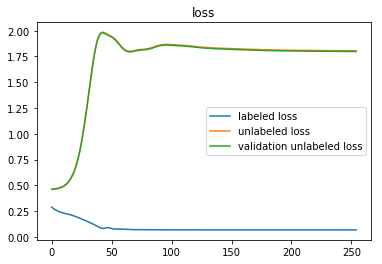

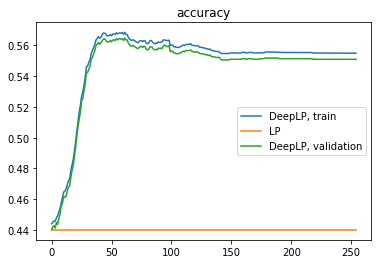

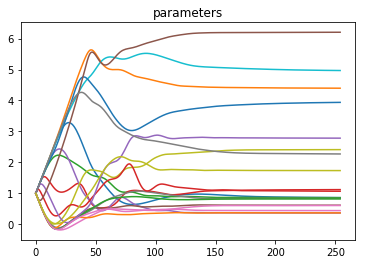

In [11]:
dlp.plot()

In [9]:
sigmas = [i for i in np.arange(0.1,5,0.1)]

In [10]:
accuracies = []
rmses = []

for i,sigma_ in enumerate(sorted(sigmas)):
    print(i)
    if i % 50 == 0:
        print(i)
    dlp_rbf = DeepLP_RBF_Sparse(100, num_nodes, features, graph, sigma, lr=10)
    pred_dlp_rbf = dlp_rbf.labelprop(test_data)
    Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

    accuracies.append(accuracy(Uy_sol,Uy_dlp_rbf))
    rmses.append(rmse(Uy_sol,Uy_dlp_rbf))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


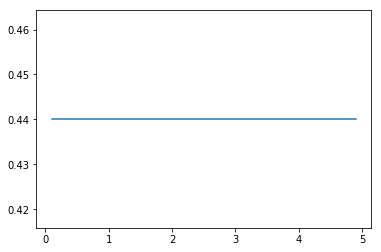

In [11]:
plt.plot(sigmas,accuracies)